# Фреймворк PyTorch для разработки искусственных нейронных сетей
# Урок 7. Рекурентные сети для обработки последовательностей

# <font color='red'>Практическое задание</font>

### Домашнее задание к уроку 7

Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции 
 
#### y=sin(x)/x-x/10
 
 При выполнении данного задания структура GAN остается той же, но Вам нужно:
- Сгенерировать настоящие данные
- Изменить архитектуру дискриминатора и генератора
- Без графиков домашку не принимаю

Выполнил ___Соковнин ИЛ___

In [1]:
import os
import numpy as np
import math

import matplotlib.pyplot as plt

#### Построим график функции

$$y=\frac{sin(x)}{x}-\frac{x}{10}$$

In [2]:
MIN_X = -15
MAX_X = 15

In [3]:
x = np.linspace(MIN_X, MAX_X, 3500)
y = lambda x: ((np.sin(x)/x) - (x/10))

In [4]:
print(len(x), len(y(x)))
x, y(x)

3500 3500


(array([-15.        , -14.99142612, -14.98285224, ...,  14.98285224,
         14.99142612,  15.        ]),
 array([ 1.54335252,  1.54295281,  1.5425504 , ..., -1.45402005,
        -1.45533242, -1.45664748]))

<function matplotlib.pyplot.show(close=None, block=None)>

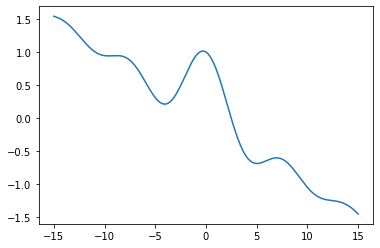

In [5]:
plt.plot(x, y(x))
plt.show

In [6]:
import torch.nn as nn
import torch

Определим нужное нам устройство:

In [7]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


### - Сгенерировать настоящие (обучающие) данные

In [8]:
BATCH_SIZE = 256
DATA_SIZE = BATCH_SIZE * 300

NUM_POINT = 100500

In [9]:
real_x = np.linspace(MIN_X, MAX_X, NUM_POINT)  # Return evenly spaced numbers over a specified interval.
np.random.shuffle(real_x)  ## shuffle (перемешать) the array 
real_x = real_x[: DATA_SIZE]
real_y = y(real_x)

print(real_x.shape[0])

76800


In [10]:
# Create an array.
real_data = np.array([[real_x[i], real_y[i]] for i in range(real_x.shape[0])])
real_data

array([[-11.03667698,   1.01313724],
       [-10.42353655,   0.96169009],
       [ -9.46979572,   0.94222735],
       ...,
       [  7.17395198,  -0.60900946],
       [ 14.72775849,  -1.41637817],
       [ -9.87457587,   0.94342698]])

In [11]:
256 * 300

76800

In [12]:
real_loader = torch.utils.data.DataLoader(
    real_data, 
    batch_size=BATCH_SIZE,
    num_workers=1,
    shuffle=True,
)

real_loader.dataset.data.shape

(76800, 2)

### 2. Создание модели

#### 2.1 Генератор:

Генератор G предназначен для отображения вектора скрытого пространства (z) в пространство данных. 

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        def block(in_feat, out_feat, normalize=True):  # activation='relu
            layers = [nn.Linear(in_feat, out_feat)]  # Если мы создаем последовательность слоев - то мы задаем их
                                                     # с помощью списка.
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(LATENT_DIM, 128, normalize=False),  # Звездочка означает unpacking списка
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 2)
#             nn.Linear(1024, int(np.prod(img_shape))),
#             nn.Tanh()  # переводит набор чисел в диапазон от -1 до 1
        )

    def forward(self, z):
        img = self.model(z)
#         img = img.view(img.size(0), *img_shape)
        return img

In [14]:
from torch.autograd import Variable  # Variable это надстройка над Tensor, 
# которая позволяет подсчитывать градиенты для обратного распространения ошибки.

#### 2.2 Дискриминатор:

Создаём свой слой

In [15]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) # Обьявляем веса кка параметры слоя

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.005, 0.005) 
        nn.init.uniform_(self.bias, -0.005, 0.005)  

    def forward(self, x):
        # По формуле линейного слоя, нам нужно умножить наши данные на трнспонированные веса и добавить смещение
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  

#### Создаем дискриминатор

In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),  # на выходе 1 unit, на котором будет решаться задача классификации
            nn.Sigmoid(),
        )
  

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

# 3. Обучение

Инициализация:

In [17]:
n_epochs = 200 # количество эпох
lr = 0.0002 # шаг обучения

b1 = 0.5 # гиперпараметр для оптимайзера Adam
b2 = 0.999 # гиперпараметр для оптимайзера Adam

LATENT_DIM = 100 # Размерность случайного вектора, который подается на вход генератору
sample_interval = 25 # количество картинок для отображения процесса обучения

In [18]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

In [19]:
# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Функция ошибки одна общая
adversarial_loss = torch.nn.BCELoss()

In [20]:
d_loss_history = []
g_loss_history = []

In [21]:
from IPython import display

Процесс обучения:

[Epoch 199/200] [Batch 281/256] [D loss: 0.695720] [G loss: 0.686756]


<Figure size 432x288 with 0 Axes>

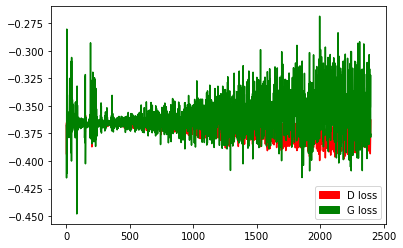

In [22]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')

for epoch in range(n_epochs):
           
#     for i, (imgs, labels) in enumerate(real_data):
      for i, data in enumerate(real_loader):
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.FloatTensor(BATCH_SIZE, 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(BATCH_SIZE, 1).fill_(0.0).to(device)

#       real_imgs = imgs.type(torch.FloatTensor).to(device)
        real_data = Variable(data.type(torch.FloatTensor)).to(device)

######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
    
        #генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))).to(device)  # размерность нашего вектора (выставляем сами)
        
        # Генерируем даные Генератором на основе шума
        gen_imgs = generator(z)
        
        # Подаем сгенерированые данные на Дискриминатор 
        validity = discriminator(gen_imgs)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(validity, valid)
        
        # Делаем шаг обучения нашего Генератора
        g_loss.backward()
        optimizer_G.step()
        
######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()
        
        # Получаем предсказания дискриминатора на основе реальных данных
#         real_pred = discriminator(real_imgs)
        real_pred = discriminator(real_data)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Опять делаем предсказание на Дискриминаторе с помощью сгенерированных данных
        fake_pred = discriminator(gen_imgs.detach())
        
        # расчитываем ошибку предсказанного с фейковыми лейблами (36:30)
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
            with torch.no_grad():
                plt.clf()

                display.clear_output(wait=False)
#                 sample_image(gen_imgs)
#                 print(gen_imgs)
                print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) ) 


                display.display(plt.gcf())

                d_loss = d_loss.cpu().detach()
                g_loss = g_loss.cpu().detach()


                d_loss_history.append(d_loss)
                
                
                g_loss_history.append(g_loss)

                plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
                plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
                plt.legend(handles=[red_patch, green_patch])
                plt.show()


In [23]:
generator.eval()

x = torch.FloatTensor(
        np.random.normal(
                    0, 1, (BATCH_SIZE, LATENT_DIM)
            )
        ).to(device)  # размерность нашего вектора (выставляем сами)

with torch.no_grad():
    pred = generator(x)

pred = pred.cpu().detach().numpy()

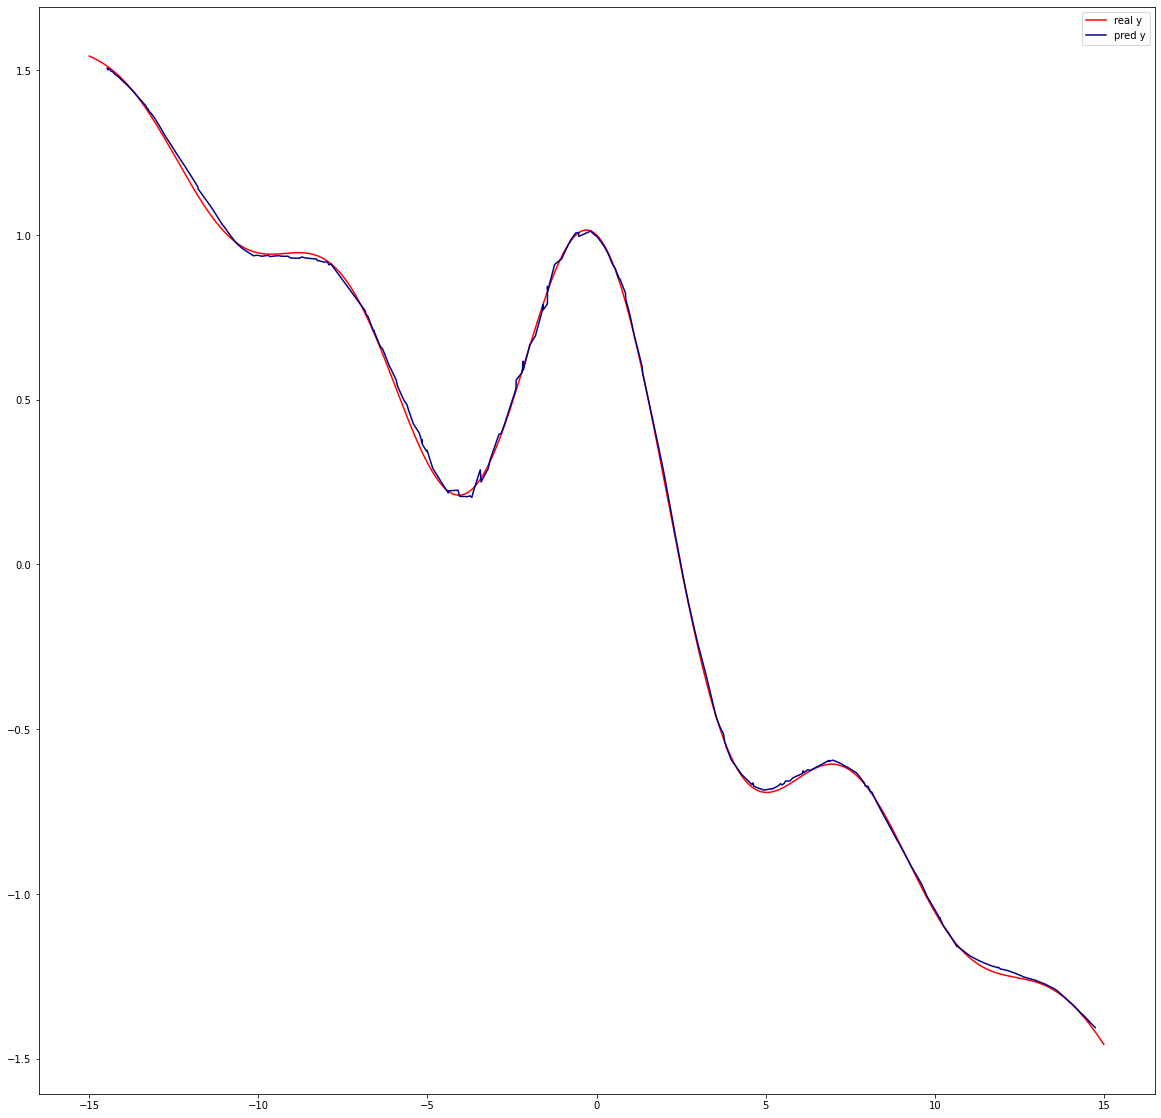

In [24]:
from matplotlib.pyplot import figure

figure(num=None, figsize=(20, 20))

real_x = np.linspace(MIN_X, MAX_X, 3500)
plt.plot(real_x, y(real_x), label='real y', color = 'red')

p = pred[:,0].argsort()
plt.plot(pred[:,0][p], pred[:, 1][p], label='pred y', color = 'darkblue')

plt.legend()
plt.show()